In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp ./drive/MyDrive/NLP/glove.6B.zip.1 ./
!cp ./drive/MyDrive/NLP/vaccine_train_set.csv ./
!cp ./drive/MyDrive/NLP/vaccine_validation_set.csv ./
!unzip ./glove.6B.zip.1

Archive:  ./glove.6B.zip.1
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [3]:
from typing import Callable, Iterable, List, Dict, Tuple
from numbers import Number
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

from sklearn.metrics import f1_score, recall_score, precision_score, \
                            roc_curve, auc, ConfusionMatrixDisplay

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

In [5]:
TRAIN_SET_PATH = "./vaccine_train_set.csv"
VALIDATION_SET_PATH = "./vaccine_validation_set.csv"
EMBEDDINGS_PATH = './glove.6B.100d.txt'

In [6]:
NUM_CLASSES = 3
CLASS_NAMES = ['Neutral', 'Anti-Vaccine', 'Pro-Vaccine']
EPOCHS = 15
LEARNING_RATE = 0.005
BATCH_SIZE = 256
HIDDEN_SIZES = [64, 16]
USE_SKIP = False

### Checking the CSV's for empty/null cells

In [7]:
trainDF = pd.read_csv(TRAIN_SET_PATH)
trainDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

In [8]:
validDF = pd.read_csv(VALIDATION_SET_PATH)
validLabels = validDF['label'].values
validDF.isnull().sum()

Unnamed: 0    0
tweet         0
label         0
dtype: int64

### Creating word vectors from the given embeddings file

In [9]:
def createWordVectors(embeddingsPath: str):
    wordVectors: Dict[str, np.ndarray] = {}
    lineElements: List[str] = []
    with open(embeddingsPath) as file:
        # Read file line by line
        for line in file:
            # Remove new line and split
            lineElements = line.replace('\n', '').split()
            # The first element in the line is the target word
            word = lineElements.pop(0)
            # The other elements represent the vector of the word
            wordVector = np.array([float(w) for w in lineElements])
            # Store the vector for this word
            wordVectors[word] = wordVector
    dimensions = len(lineElements)

    return wordVectors, dimensions

wordVectors, dimensions = createWordVectors(EMBEDDINGS_PATH)

### Optional Preprocessor to be used during data vectorization
- Converts the given `str` to lowercase
- Ignores `@` mentions
- Ignores URL's starting with `http://` or `https://`
- Ignores any digits

In [10]:
def customPreprocessor(text: str):    
    # remove url's
    trimmedText = re.sub(r'https?://\S+|www\.\S+|#', '', text).lower()

    # remove @ mentions and numbers
    res = list()
    wait_whitespace = False
    for c in trimmedText:
        if wait_whitespace:
            if c == " ":
                wait_whitespace = False
            continue
        elif re.match("[0-9]", c) or c == "@":
            wait_whitespace = True
            continue            
        res.append(c)
    
    return ''.join(res)

tokenizer = TweetTokenizer()
def customTokenizer(text: str):
    return tokenizer.tokenize(customPreprocessor(text))


### Vectorizing Data set Samples
- Each sentence is tokenized using `nltk.TweetVectorizer` into tokens/words.
- We sum up the vectors of each word from the pre-trained embeddings and assign the mean vector to the current sample.

In [11]:
# nltk.TweetTokenizer is used for tweet tokenization

def vectorizeTweet(tweet: str, preprocessor: Callable[[str], str], wordVectors: Dict[str, np.ndarray], dimensions: int) -> np.ndarray:
    # Split the tweet into words/tokens
    words = tokenizer.tokenize(preprocessor(tweet))
    # words = tokenizer.tokenize(tweet)

    # The sum of the vectors of the tweet words is stored here
    vector: np.ndarray = np.zeros(dimensions)
    for word in words:
        # Get the word/token pre-trained vector
        wordVector = wordVectors.get(word)
        if wordVector is not None:
            # If found, add to the tweet vector
            vector += wordVector
    
    # return the mean vector
    return vector / len(words)

def vectorizeDataSet(dataSet: Iterable[str], dimensions: int, wordVectors: Dict[str, np.ndarray]):
    matrix: np.ndarray = np.zeros(shape=(len(dataSet), dimensions))
    for i, sample in enumerate(dataSet):
        matrix[i] = vectorizeTweet(sample, customPreprocessor, wordVectors, dimensions)
    
    return matrix

In [12]:
labelField = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
tweetField = Field(tokenize=customTokenizer, include_lengths=True, batch_first=True)
fields = [('', None), ('tweet', tweetField), ('label', labelField)]

trainDataset = TabularDataset(path=TRAIN_SET_PATH, format='CSV', fields=fields, skip_header=True,)
validDataset = TabularDataset(path=VALIDATION_SET_PATH, format='CSV', fields=fields, skip_header=True)

trainIterator = BucketIterator(trainDataset, batch_size=BATCH_SIZE)
validIterator = BucketIterator(validDataset, batch_size=len(validLabels))


tweetField.build_vocab(trainDataset)
paddingIndex = tweetField.vocab.stoi['<pad>']

In [13]:
matrixNumWords = len(tweetField.vocab)
embeddingsMatrix = torch.zeros(matrixNumWords, dimensions, dtype=torch.float)

for i, word in enumerate(tweetField.vocab.itos):
    wordVector = wordVectors.get(word)

    if wordVector is not None:
        embeddingsMatrix[i] = torch.from_numpy(wordVector)

### Converting the NN output to predictions
We apply `log_softmax` to the output vector and map each vector to the index of the maximum element of the vector.

In [14]:
def getPredictedLabels(predictions: torch.Tensor) -> np.ndarray:
    softmaxLayerOut = torch.log_softmax(predictions, dim = 1)
    _, labels = torch.max(softmaxLayerOut, dim = 1)
    return labels.detach().numpy()

### Calculating macro accuracy

In [15]:
def calculateAccuracy(predictedLabels: Iterable[Number], trueLabels: Iterable[Number]) -> float:    
    correct = 0
    for pred, true in zip(predictedLabels, trueLabels):
        correct += int(pred == true)
    
    return correct/len(trueLabels)*100

### Plotting a confusion matrix
We can change the displayed labels (`0` -> `Neutral`, `1` -> `Anti-Vaccine`, `2` -> `Pro-Vaccine`) if desired.

In [16]:
def plotConfusionMatrix(trueLabels: Iterable[int], predictions:Iterable[int], title: str, displayLabels: Iterable[str]=None, axes: plt.Axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(6,5))
    disp = ConfusionMatrixDisplay.from_predictions(trueLabels, predictions, cmap=plt.cm.Reds, ax=axes, colorbar=False)
    if displayLabels is not None:
        disp.ax_.set_xticklabels(displayLabels)
        disp.ax_.set_yticklabels(displayLabels)
    axes.set_xlabel('Classifier predicted labels', fontsize=11)
    axes.set_ylabel('True labels', fontsize=11)
    axes.set_title(title, fontsize=14)

### Plotting F1 learning curves
We calculate the F1 score on the Train and Validation sets after every epoch, to create the corresponding F1 learning curves.

In [17]:
def displayF1Curves(epochs: int, tScores: Iterable[Number], vScores: Iterable[Number]):

    epochValues = [i for i in range(epochs)]

    _, axes = plt.subplots(1, 1, figsize=(7, 6))
    axes.grid()
    axes.set_title('F1 Scores')
    axes.plot(epochValues, tScores, "-", color="r", label="Training Set score")
    axes.plot(epochValues, vScores, "-", color="g", label="Validation Set score")

    yValues = np.concatenate((tScores, vScores))
    axes.set_xlim((epochValues[0], epochValues[-1]))
    axes.set_ylim(( round(min(yValues) - 0.05, 1), round(max(yValues) + 0.05, 1) ))
    axes.legend(loc="best")

    plt.show()

### Calculating metric scores on the trained model predictions
- For each different training set size, we calculate the **F1**, **Precision** and **Recall** scores
of the predictions made by the classifier after the end of the train phase, on the training & validation sets.
- We store these scores in two `dict` objects which we return.

In [18]:
F1_KEY = "F1"
PREC_KEY = "Precision"
REC_KEY = "Recall"

def metricScores(trainPredictions: Iterable[int], validPredictions: Iterable[int], trainLabels: Iterable[int], validLabels: Iterable[int]):
    tScores = {}
    vScores = {}
    tScores[F1_KEY] = round(f1_score(trainLabels, trainPredictions, average="micro"), 4)
    tScores[PREC_KEY] = round(precision_score(trainLabels, trainPredictions, average="macro"), 4)
    tScores[REC_KEY] = round(recall_score(trainLabels, trainPredictions, average="macro"), 4)

    vScores[F1_KEY] = round(f1_score(validLabels, validPredictions, average="micro"), 4)
    vScores[PREC_KEY] = round(precision_score(validLabels, validPredictions, average="macro"), 4)
    vScores[REC_KEY] = round(recall_score(validLabels, validPredictions, average="macro"), 4)
    
    return tScores, vScores

### Getting the final scores in a data frame
We place the scores of the predictions made after the end of training in a data frame for better readability.

In [19]:
def metricStatsDF(tScores: Dict[str, Number], vScores: Dict[str, Number]):
    metricStats: Dict[str, List[Number]] = {}
    for metric in tScores:
        metricStats[metric] = [tScores[metric], vScores[metric]]
    
    return pd.DataFrame(metricStats, index=['Train', 'Validation'])

### Plotting Loss curves for the after-training predictions on the Training & Validation sets

In [20]:
def plotLossCurves(trainLosses: Iterable[Number], validationLosses: Iterable[Number], axes: plt.Axes = None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(6,5))
    
    axes.grid()
    axes.set_title("Loss Curves", fontsize=14)
    axes.set_xlabel('Epochs', fontsize=12)
    axes.set_ylabel('Loss', fontsize=12)
    
    epochs = [i for i in range(len(validationLosses))]

    axes.plot(epochs, trainLosses, label='Train Set')
    axes.plot(epochs, validationLosses, label='Validation Set')

    axes.legend(loc="best")
    plt.show()

### Creating & Plotting ROC Curves for the Validation Set predictions
We mirror the usage of `roc_curve` from scikit-learn for multiple classes, as demonstrated [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#plot-roc-curves-for-the-multiclass-problem).

In [21]:
def createRocCurves(trueLabels: Iterable[int] , predictions: torch.Tensor):
    labels = np.zeros((len(trueLabels), NUM_CLASSES), dtype=int)
    for index, label in enumerate(trueLabels):
        labels[index][label] = 1
    scores = torch.softmax(predictions, dim = 1).detach().numpy()

    fpr: Dict[int, np.ndarray] = {}
    tpr: Dict[int, np.ndarray] = {}
    roc_auc: Dict[int, np.ndarray] = {}
    for i in range(NUM_CLASSES):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], scores[:, i], drop_intermediate=True)
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    return fpr, tpr, roc_auc

def plotRocCurves(fpRates: Dict[int, np.ndarray], tpRates: Dict[int, np.ndarray], aucScores: Dict[int, np.ndarray]):
    plt.figure(figsize=(7,7))
    plt.grid()

    for i in range(NUM_CLASSES):
        plt.plot(
            fpRates[i],
            tpRates[i],
            label=f"{CLASS_NAMES[i]} (area = {aucScores[i]:0.2f})"
        )

    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.show()
    pass

### Creating the Neural Network
TODO

In [22]:
class SkipRNN(nn.Module):
    def __init__(self, embeddingsMatrix, vectorDimension: int, hiddenSizes: Iterable[int], skipConnections: bool = True) -> None:
        super().__init__()

        self.USE_SKIP = skipConnections
        self.vectorDimension = vectorDimension
        self.embedding = nn.Embedding.from_pretrained(embeddingsMatrix)
        
        self.startingLayer = nn.LSTM(   input_size=vectorDimension,
                                        hidden_size=hiddenSizes[0],
                                        num_layers=1,
                                        batch_first=True,
                                        bidirectional=False )
        self.lstmLayers = nn.ModuleList()
        for i in range(1, len(hiddenSizes)):
            self.lstmLayers.append(nn.LSTM( input_size=hiddenSizes[i - 1],
                                            hidden_size=hiddenSizes[i],
                                            num_layers=1,
                                            batch_first=True,
                                            bidirectional=False))

        self.linear = nn.Linear(hiddenSizes[-1], NUM_CLASSES)
        self.activation = nn.Tanh()
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p=0.5)

        if (skipConnections):
            self.skip = nn.Identity()

    def forward(self, input, inputLengths):
        embout = self.embedding(input)
        
        nextInput, _ = self.startingLayer(embout)
        nextSkipInput = nextInput
        for layer in self.lstmLayers:
            output, _ = layer(self.drop(nextInput))
            if self.USE_SKIP and (nextSkipInput is not None):
                nextInput = torch.add(output, self.skip(nextSkipInput))
                nextSkipInput = None
            else:
                nextSkipInput = output
                nextInput = self.relu(output)

        lstmOutput = nextInput[:, -1, :]
        classOutput = self.linear(lstmOutput)
        
        return classOutput


In [23]:
model = SkipRNN(embeddingsMatrix, dimensions, hiddenSizes=HIDDEN_SIZES, skipConnections=USE_SKIP)

In [24]:
lossFunction = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
# Loss, F1 Score & Total Predictions after every epoch are stored here
validPredictions: np.ndarray
validF1: np.ndarray = np.empty(EPOCHS, dtype=float)
validErrors: np.ndarray = np.empty(EPOCHS, dtype=float)
validOutput: torch.Tensor

trainF1: np.ndarray = np.empty(EPOCHS, dtype=float)
trainErrors: np.ndarray = np.empty(EPOCHS, dtype=float)
epochTrainPredictions: List[int]

# Epochs loop
for epoch in range(EPOCHS):
    # Set model to train mode
    epochLabels = []
    epochTrainPredictions = []
    batchLosses = []
    batchAccs = []
    model.train()

    # Batch loop
    for ((tweets, tweetsLen), labels), _ in trainIterator:
        
        # Make predictions for batch samples
        predictions = model(tweets, tweetsLen)

        # Extract & store predicted labels and calculate accuracy
        predictedLabels = getPredictedLabels(predictions)
        epochTrainPredictions.extend(predictedLabels)
        batchAccs.append(calculateAccuracy(predictedLabels, labels))

        # Run loss function, store loss & backpropagate
        batchLoss = lossFunction(predictions, labels.long())
        batchLosses.append(batchLoss.item())

        optimizer.zero_grad()

        batchLoss.backward()

        optimizer.step()
        epochLabels.extend(labels)
        # Set model to evaluation mode

    model.eval()
    with torch.no_grad():
        
        for ((tweets, tweetsLen), labels), _ in validIterator:
          # Make predictions on the Validation set
          validOutput = model(tweets, tweetsLen)

          # Run loss function & store loss
          validLoss = lossFunction(validOutput, labels.long())
          validErrors[epoch] = validLoss.item()
          
          # Extract & store predicted labels, calculate accuracy and F1 Score
          validPredictions = getPredictedLabels(validOutput)
          acc = calculateAccuracy(validPredictions, labels)
          validF1[epoch] = f1_score(labels, validPredictions, average="micro")

    # Find the total epoch loss & F1 Score for the Train set
    trainErrors[epoch] = sum(batchLosses)/len(batchLosses)
    trainF1[epoch] = f1_score(epochLabels, epochTrainPredictions, average="micro")
    
    print(f"Epoch {epoch:2} Train Acc = {sum(batchAccs)/len(batchAccs):.5f} Valid Acc = {acc:.5f}\r")

Epoch  0 Train Acc = 45.34303 Valid Acc = 46.93252
Epoch  1 Train Acc = 47.48979 Valid Acc = 47.10780
Epoch  2 Train Acc = 49.17630 Valid Acc = 56.48554
Epoch  3 Train Acc = 56.57624 Valid Acc = 62.09465
Epoch  4 Train Acc = 63.91989 Valid Acc = 65.68799
Epoch  5 Train Acc = 64.08253 Valid Acc = 62.53287
Epoch  6 Train Acc = 65.71181 Valid Acc = 66.95881
Epoch  7 Train Acc = 67.07732 Valid Acc = 67.57230
Epoch  8 Train Acc = 67.82996 Valid Acc = 67.17791
Epoch  9 Train Acc = 68.21629 Valid Acc = 67.61613
Epoch 10 Train Acc = 68.72043 Valid Acc = 67.65995
Epoch 11 Train Acc = 69.02473 Valid Acc = 67.00263
Epoch 12 Train Acc = 69.65383 Valid Acc = 68.75548
Epoch 13 Train Acc = 71.08993 Valid Acc = 69.06223
Epoch 14 Train Acc = 71.57547 Valid Acc = 69.41280


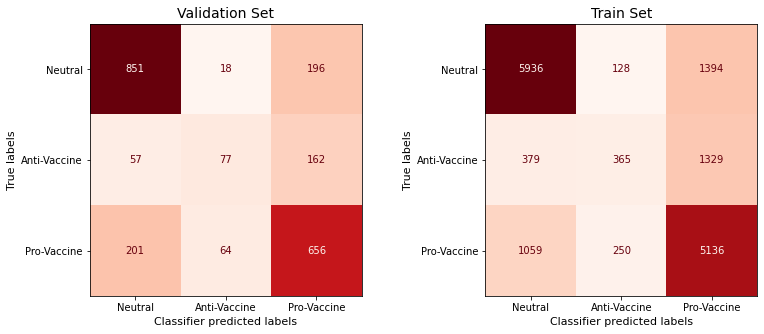

In [26]:
_, ax = plt.subplots(1, 2, figsize=(13,5))
plotConfusionMatrix(labels, validPredictions, 'Validation Set', CLASS_NAMES, ax[0])
plotConfusionMatrix(epochLabels, epochTrainPredictions, 'Train Set', CLASS_NAMES, ax[1])
plt.show()

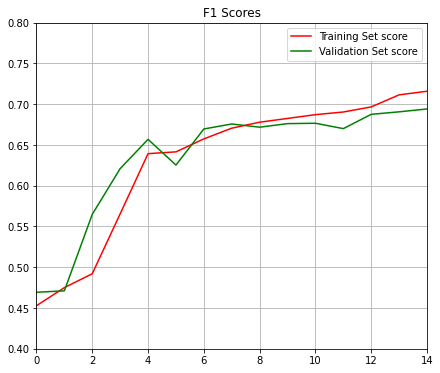

In [27]:
displayF1Curves(EPOCHS, trainF1, validF1)

In [28]:
scores = metricScores(epochTrainPredictions, validPredictions, epochLabels, labels)
metricStatsDF(*scores)

,F1,Precision,Recall
Train,0.7159,0.6499,0.5896
Validation,0.6941,0.6329,0.5905


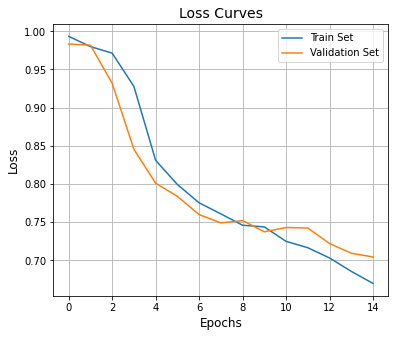

In [29]:
plotLossCurves(trainErrors, validErrors)

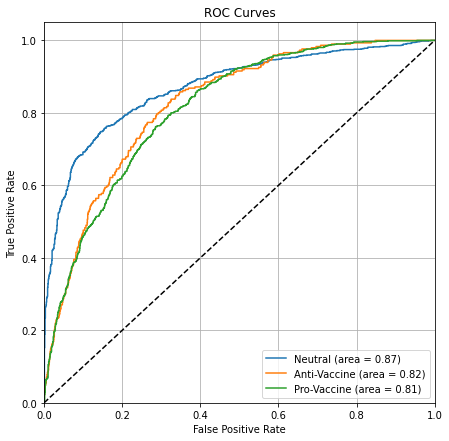

In [30]:
rocScores = createRocCurves(labels.int(), validOutput)
plotRocCurves(*rocScores)